<a href="https://colab.research.google.com/github/Ahmad-abdulrahim/Personalized-Job-Matching-System/blob/Development/Job_Classifier_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import necessary libraries**

In [1]:
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical computations
import re           # For regular expressions
import nltk         # Natural Language Toolkit
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords   # Stopwords
from nltk.tokenize import word_tokenize  # Tokenization
from nltk.stem import WordNetLemmatizer  # Lemmatization
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# JOB POSTINGS DATASET EXPLORATION

## Dataset information

In [2]:
from google.colab import files
files.upload()  # Upload your Kaggle API token (kaggle.json)
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!kaggle datasets download -d udacity/armenian-online-job-postings

Saving kaggle.json to kaggle.json
 71% 10.0M/14.0M [00:00<00:00, 105MB/s]
100% 14.0M/14.0M [00:00<00:00, 126MB/s]


In [3]:
!unzip armenian-online-job-postings.zip

Archive:  armenian-online-job-postings.zip
  inflating: example-job-posting.jpg  
  inflating: features.txt            
  inflating: online-job-postings.csv  


In [4]:
jobs = pd.read_csv("online-job-postings.csv")

# Sample 1000 records from df
#jobs = jobs.sample(n=min(len(jobs), 1000), random_state=42)

jobs.head()

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\r\nJOB TI...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\r\...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\r\...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\r\nJ...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\r\nPOSITION,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\r\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\r\...,NaN,2004,1,False
3,Manoff Group\r\nJOB TITLE: BCC Specialist\r\n...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\r\n...,NaN,23 January 2004\r\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,Yerevan Brandy Company\r\nJOB TITLE: Software...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Successful candidates should submit\r\n- CV; \...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


In [5]:
jobs.columns

Index(['jobpost', 'date', 'Title', 'Company', 'AnnouncementCode', 'Term',
       'Eligibility', 'Audience', 'StartDate', 'Duration', 'Location',
       'JobDescription', 'JobRequirment', 'RequiredQual', 'Salary',
       'ApplicationP', 'OpeningDate', 'Deadline', 'Notes', 'AboutC', 'Attach',
       'Year', 'Month', 'IT'],
      dtype='object')

In [6]:
jobs.shape

(19001, 24)

In [7]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   jobpost           19001 non-null  object
 1   date              19001 non-null  object
 2   Title             18973 non-null  object
 3   Company           18994 non-null  object
 4   AnnouncementCode  1208 non-null   object
 5   Term              7676 non-null   object
 6   Eligibility       4930 non-null   object
 7   Audience          640 non-null    object
 8   StartDate         9675 non-null   object
 9   Duration          10798 non-null  object
 10  Location          18969 non-null  object
 11  JobDescription    15109 non-null  object
 12  JobRequirment     16479 non-null  object
 13  RequiredQual      18517 non-null  object
 14  Salary            9622 non-null   object
 15  ApplicationP      18941 non-null  object
 16  OpeningDate       18295 non-null  object
 17  Deadline    

## Dataset Cleaning

In [8]:
#removing duplicate jobposts based on title and post
jobs = jobs.drop_duplicates(['jobpost', 'Title'])

In [9]:
#removing records with null titles
jobs = jobs[jobs.Title.notna()]

In [10]:
jobs.shape

(18865, 24)

In [11]:
# Remove leading and trailing spaces from column names
jobs.columns = jobs.columns.str.strip()
# Rename specific columns for clarity and consistency
jobs.rename(columns={'date': 'Date', 'jobpost': 'Jobpost', 'RequiredQual': 'RequiredQualifications', 'JobRequirment': 'JobRequirement'}, inplace=True)

In [12]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18865 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Jobpost                 18865 non-null  object
 1   Date                    18865 non-null  object
 2   Title                   18865 non-null  object
 3   Company                 18865 non-null  object
 4   AnnouncementCode        1202 non-null   object
 5   Term                    7650 non-null   object
 6   Eligibility             4869 non-null   object
 7   Audience                631 non-null    object
 8   StartDate               9638 non-null   object
 9   Duration                10752 non-null  object
 10  Location                18840 non-null  object
 11  JobDescription          15040 non-null  object
 12  JobRequirement          16409 non-null  object
 13  RequiredQualifications  18437 non-null  object
 14  Salary                  9582 non-null   object
 15  Ap

In [13]:
# Convert all column values to string type except for the 'IT' column, preserving NaN values
for col in jobs.columns:
    if col != 'IT':  # Skip the "IT" column
        jobs[col] = jobs[col].apply(lambda x: x if pd.isna(x) else str(x))

In [14]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18865 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Jobpost                 18865 non-null  object
 1   Date                    18865 non-null  object
 2   Title                   18865 non-null  object
 3   Company                 18865 non-null  object
 4   AnnouncementCode        1202 non-null   object
 5   Term                    7650 non-null   object
 6   Eligibility             4869 non-null   object
 7   Audience                631 non-null    object
 8   StartDate               9638 non-null   object
 9   Duration                10752 non-null  object
 10  Location                18840 non-null  object
 11  JobDescription          15040 non-null  object
 12  JobRequirement          16409 non-null  object
 13  RequiredQualifications  18437 non-null  object
 14  Salary                  9582 non-null   object
 15  Ap

## Exploratory Data Analysis (EDA)


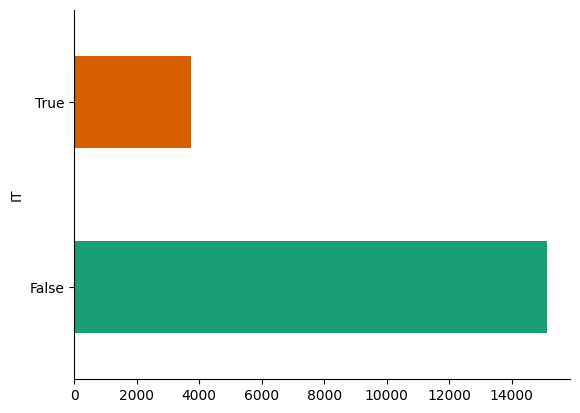

In [15]:
# Plot horizontal bar chart of the number of records for each 'IT' category
from matplotlib import pyplot as plt
import seaborn as sns
jobs.groupby('IT').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))  # Group by 'IT', count, and plot
plt.gca().spines[['top', 'right',]].set_visible(False)  # Hide top and right spines for aesthetics

In [16]:
# Load the small English model from spaCy with default pipeline components for basic text processing
nlp = spacy.load("en_core_web_sm")

In [17]:
def preprocess_text_spacy(text):
    """
    Advanced text preprocessing using spaCy.
    """
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = text.strip().lower()  # Strip whitespace and convert to lowercase
    doc = nlp(text)  # Process text with spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]  # Lemmatize, remove stopwords and punctuation
    return " ".join(tokens)  # Join tokens into a string

In [18]:
title = jobs.Title.apply(lambda x : preprocess_text_spacy(x))  # Apply preprocessing function to 'Title' column
title.head()  # Display the first 5 processed titles

0                              chief financial officer
1    fulltime community connection intern pay inter...
2                                  country coordinator
3                                       bcc specialist
4                                   software developer
Name: Title, dtype: object

To gain insight into the most sought-after jobs in Armenia, we can analyze job titles using a technique that constructs a document-term matrix (DTM) based on bi-grams or tri-grams. A bi-gram or tri-gram approach breaks down the job titles into pairs or triplets of consecutive words, respectively. By creating this matrix, we can identify which combinations of words (tokens) appear most frequently within the job titles. The most frequently occurring bi-gram or tri-gram can be interpreted as an indicator of the job roles that are currently in highest demand.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer for tokenization, using unigrams
count_vect = CountVectorizer(ngram_range=(1,1))
token = count_vect.fit_transform(title)  # Fit and transform the 'title' series to tokens

In [20]:
print('Total number of tokens/words in all the job titles - ',
      len(count_vect.get_feature_names_out()))

Total number of tokens/words in all the job titles -  2858


In [21]:
title_df =  pd.DataFrame(token.toarray(), columns=count_vect.get_feature_names_out())
title_df.tail()

,aaca,abap,abatement,abattoir,abkhazia,abovyan,abuse,ac,academy,acca,...,yoga,young,youth,zang,zend,zonal,zone,zooplankton,zvartnot,zvartnots
18860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18864,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#count the occurence of each token in entire corpus
title_count_df = title_df.apply(lambda x : x.sum())

In [23]:
title_count_df = pd.DataFrame(title_count_df).reset_index()

In [24]:
title_count_df.columns = ['Word', 'Count']

In [25]:
top_title = title_count_df.sort_values(by= 'Count', ascending=False)
top_title[:15]

,Word,Count
1551,manager,2587
2411,specialist,2067
716,developer,1943
868,engineer,1603
2325,senior,1490
208,assistant,1234
2390,software,1099
2260,sale,853
15,accountant,779
704,department,742


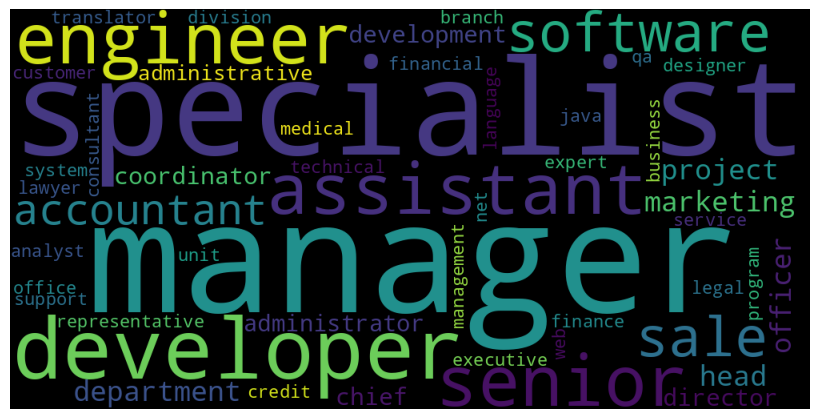

In [26]:
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(top_title[:50].Word))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

A dispersion plot can be utilized to track the evolution of job roles over time. This involves extracting key topics from job postings and then visualizing their frequency and distribution across different time periods. Essentially, by identifying and plotting these significant themes, we can observe trends and shifts in job demands over the years, providing insights into how certain job roles emerge, evolve, or decline.

In [28]:
jobpost = jobs.Jobpost.apply(lambda x : preprocess_text_spacy(x))
jobpost.head(10)

0    ameria investment consult company job title ch...
1    international research exchange board irex tit...
2    caucasus environmental ngo network cenn job ti...
3    manoff group job title bcc specialist position...
4    yerevan brandy company job title software deve...
5    boutique appollo job title saleswoman position...
6    osi assistance foundation armenian branch offi...
7    international research exchange board irex tit...
8    yerevan brandy company job title assistant man...
9    american embassy yerevan announcement number j...
Name: Jobpost, dtype: object

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer with specific conditions and apply it to 'jobpost'
tfidf = TfidfVectorizer(ngram_range=(1,1), min_df=0.05, max_df=0.95)
token_jobpost = tfidf.fit_transform(jobpost)  # Fit and transform 'jobpost' to TF-IDF features
vocab = tfidf.get_feature_names_out()  # Extract the vocabulary of terms found in the documents

In [30]:
token_df = pd.DataFrame(token_jobpost.toarray(), columns=tfidf.get_feature_names_out())
token_df.head()

,ability,access,accord,accordance,account,accountant,accounting,accuracy,accurate,achieve,...,visit,web,willingness,word,work,world,write,writing,year,yerevan
0,0.042691,0.0,0.0,0.0,0.098778,0.0,0.237305,0.0,0.0,0.035535,...,0.0,0.0,0.000000,0.027493,0.056359,0.000000,0.000000,0.033289,0.013284,0.010076
1,0.037012,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.029318,0.000000,0.049852,0.000000,0.000000,0.157241
2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.065603,0.000000,0.055776,0.000000,0.038655,0.029321
3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.044762,0.035381,0.087035,0.041714,0.024666,0.000000,0.017095,0.000000
4,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.063992,0.145618


Latent Dirichlet Allocation (LDA) technique, a type of topic modeling, to analyze and understand the main themes or natures of jobs from tokenized job postings. The goal is to identify clusters of words that represent significant topics within the job posts, which can help in understanding the nature and profiles of jobs.

In [31]:
# Apply LDA to discern significant aspects of job nature and profiles
from sklearn import decomposition

# Initialize LDA model
lda = decomposition.LatentDirichletAllocation(n_components=5, learning_method='online', max_iter=50, random_state=3)
lda.fit_transform(token_jobpost)  # Fit and transform TF-IDF features to LDA
topics = lda.components_  # Extract the components (topics) from the LDA model

In [32]:
topics

array([[1.49707594e+02, 4.72532780e+01, 2.98554177e+01, ...,
        4.33108747e+01, 1.24226517e+02, 1.26000248e+02],
       [3.82490300e+01, 2.04009052e-01, 2.06376630e-01, ...,
        2.08909164e+00, 2.15292280e+01, 8.69365443e+01],
       [2.81058504e+02, 1.98715760e+01, 5.70973409e+01, ...,
        5.11496146e+01, 1.38395152e+02, 2.18893532e+02],
       [1.42007182e+02, 1.04059742e+01, 6.19827049e+01, ...,
        1.12110743e+01, 1.27322532e+02, 1.18366910e+02],
       [2.53723872e+02, 2.66839618e+01, 6.29830208e+01, ...,
        3.63426712e+01, 1.82515601e+02, 1.68935486e+02]])

In [33]:
# Generate summaries for each topic with the top words
n_top_words = 15
topic_summaries = []
for i, topic_dist in enumerate(topics):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]  # Select top words for each topic
    topic_summaries.append(' '.join(topic_words))  # Create summary string

topic_summaries  # Display the topic summaries

['project program development international work management training support activity community experience implementation provide office skill',
 'medical representative company language ltd knowledge russian llc yerevan work photo education send english armenian',
 'sale customer marketing company skill work knowledge service candidate manager language ability excellent llc experience',
 'bank accounting financial credit knowledge finance banking cjsc accountant legal tax form candidate work report',
 'software design development developer experience knowledge web work engineer test system company team technical technology']

In [34]:
topic_words_tokens = []
for topic in topic_summaries:
    word_token = nltk.word_tokenize(topic)  # Tokenize each topic summary
    topic_words_tokens.extend(word_token)  # Append tokens to list
print(topic_words_tokens)  # Print the list of tokens from all topic summaries

['project', 'program', 'development', 'international', 'work', 'management', 'training', 'support', 'activity', 'community', 'experience', 'implementation', 'provide', 'office', 'skill', 'medical', 'representative', 'company', 'language', 'ltd', 'knowledge', 'russian', 'llc', 'yerevan', 'work', 'photo', 'education', 'send', 'english', 'armenian', 'sale', 'customer', 'marketing', 'company', 'skill', 'work', 'knowledge', 'service', 'candidate', 'manager', 'language', 'ability', 'excellent', 'llc', 'experience', 'bank', 'accounting', 'financial', 'credit', 'knowledge', 'finance', 'banking', 'cjsc', 'accountant', 'legal', 'tax', 'form', 'candidate', 'work', 'report', 'software', 'design', 'development', 'developer', 'experience', 'knowledge', 'web', 'work', 'engineer', 'test', 'system', 'company', 'team', 'technical', 'technology']


In [35]:
vocab = []  # Initialize empty list to store vocabulary

def fn_token(post):
    list_temp = nltk.word_tokenize(post)  # Tokenize the post
    vocab.extend(list_temp)  # Extend the vocab list with tokens

jobpost.apply(lambda x: fn_token(x))  # Apply tokenization function to each job post

0        None
1        None
2        None
3        None
4        None
         ... 
18996    None
18997    None
18998    None
18999    None
19000    None
Name: Jobpost, Length: 18865, dtype: object

In [36]:
full_vocab = []  # Initialize empty list for unique vocabulary

for word in vocab:
    if word not in full_vocab:  # Check if word is not already in full_vocab
        full_vocab.append(word)  # Add unique word to full_vocab

In [37]:
print(full_vocab)

['ameria', 'investment', 'consult', 'company', 'job', 'title', 'chief', 'financial', 'officer', 'position', 'location', 'yerevan', 'armenia', 'description', 'seek', 'manage', 'fiscal', 'administrative', 'function', 'provide', 'highly', 'responsible', 'technically', 'complex', 'staff', 'assistance', 'executive', 'director', 'work', 'perform', 'require', 'high', 'level', 'technical', 'proficiency', 'management', 'supervisory', 'skill', 'responsibility', 'supervise', 'include', 'assign', 'review', 'employee', 'process', 'product', 'counsel', 'give', 'performance', 'evaluation', 'recommend', 'disciplinary', 'action', 'serve', 'member', 'team', 'participate', 'strategic', 'operational', 'planning', 'direct', 'oversee', 'companys', 'activity', 'establish', 'monitor', 'internal', 'control', 'cash', 'portfolio', 'collaboration', 'leader', 'limit', 'risk', 'concentration', 'fund', 'deployment', 'adequacy', 'loss', 'liquidity', 'reserve', 'assist', 'development', 'proper', 'documentation', 'syst

<Axes: title={'center': 'Lexical Dispersion Plot'}, xlabel='Word Offset'>

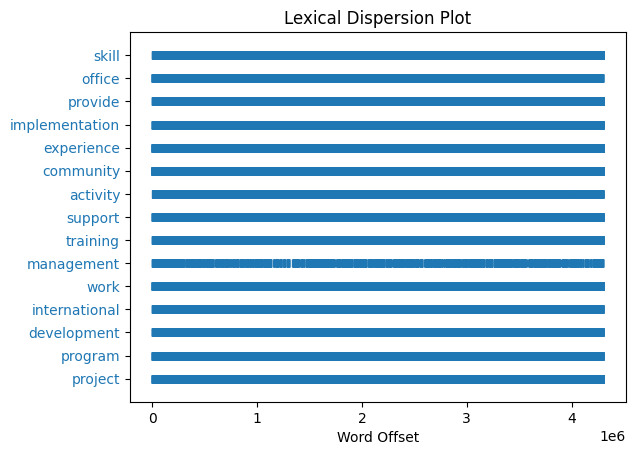

In [38]:
# Visualize the dispersion of the top 15 topic words across the text
from nltk.draw.dispersion import dispersion_plot

dispersion_plot(vocab, topic_words_tokens[:15])  # Generate dispersion plot for the first 15 tokens in topic_words_tokens

In [39]:
jobs['JobDescription'] = jobs['JobDescription'].astype('str')
description_df = jobs.JobDescription.apply(lambda x : preprocess_text_spacy(x))
description_df.head()

0    ameria investment consult company seek chief f...
1                                                  nan
2    public outreach strengthen grow network enviro...
3    lead local enhancement development health bcc ...
4                                                  nan
Name: JobDescription, dtype: object

In [40]:
#Tokenization
tfidf = TfidfVectorizer(ngram_range=(1,1), min_df = 0.05, max_df=0.95, stop_words='english')
desc_tdm = tfidf.fit_transform(description_df)

In [41]:
df_cluster = pd.DataFrame(desc_tdm.toarray(), columns=tfidf.get_feature_names_out())
df_cluster.head(10)

,activity,application,armenia,business,candidate,cjsc,company,customer,department,design,...,seek,senior,service,software,specialist,supervision,support,team,technical,work
0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.364356,0.0,0.0,0.0,...,0.164986,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.236371,0.163579
1,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
3,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.722145,0.0,0.156252,0.0,0.281526,0.0,0.000000,0.476316
4,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
5,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
6,0.000000,0.53049,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.397241,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
7,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
8,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
9,0.218104,0.00000,0.200655,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.212294,0.0,0.000000,0.000000


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.2563884730817351


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.23998362571530035


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.24280150777276488


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.24720346516480718


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.25150872600816615


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 7 The average silhouette_score is : 0.25386912930032196


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 8 The average silhouette_score is : 0.2584985464628435


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 9 The average silhouette_score is : 0.2645687410928365


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10 The average silhouette_score is : 0.2667750619648356


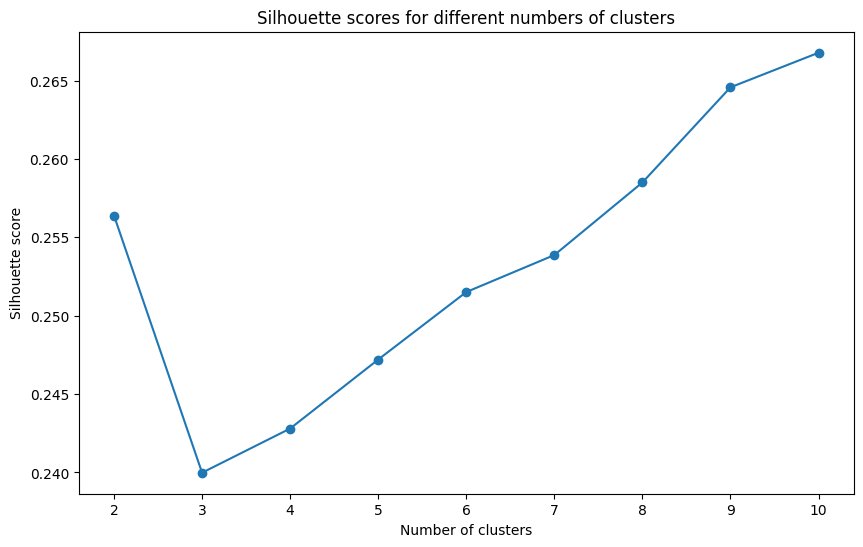

In [42]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assuming desc_tdm is your TF-IDF matrix
range_n_clusters = list(range(2, 11))  # Typically start with 2 clusters, adjust the range as needed
silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator seed for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(desc_tdm)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(desc_tdm, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

# Plotting the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o')
plt.title('Silhouette scores for different numbers of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [43]:
from sklearn.cluster import KMeans

# Apply KMeans clustering with 10 clusters, using 'k-means++' initialization, maximum of 100 iterations per run,
# 1 initialization attempt, and setting the random state to 5 for reproducibility. Fit the model to the term-document matrix (desc_tdm)
model = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1, random_state=5).fit(desc_tdm)

In [44]:
# sorting the cluster centers for clusters
sorted_vals = [model.cluster_centers_[i].argsort() for i in range(0,np.shape(model.cluster_centers_)[0])]

In [45]:
# Initialize an empty set to store the top 10 words from each cluster
words = set()

# Iterate over each cluster
for i in range(len(model.cluster_centers_)):
    # Extract the indices of the top 10 values for the current cluster
    words = set([vocab[index] for index in sorted_vals[i][-10:]])  # Select the top 10 words based on their indices
    # Print the set of top 10 words for the current cluster
    print(words)

{'investment', 'description', 'consult', 'ameria', 'fiscal', 'chief', 'officer', 'company', 'seek'}
{'investment', 'consult', 'financial', 'highly', 'staff', 'job', 'function', 'officer', 'company', 'title'}
{'investment', 'technically', 'administrative', 'manage', 'consult', 'executive', 'function', 'officer', 'proficiency', 'complex'}
{'technical', 'investment', 'manage', 'financial', 'executive', 'job', 'work', 'chief', 'officer', 'seek'}
{'investment', 'description', 'financial', 'executive', 'ameria', 'require', 'position', 'director', 'proficiency', 'complex'}
{'investment', 'yerevan', 'perform', 'financial', 'high', 'job', 'location', 'position', 'officer', 'armenia'}
{'level', 'manage', 'financial', 'executive', 'staff', 'job', 'function', 'work', 'company', 'title'}
{'technical', 'investment', 'consult', 'executive', 'ameria', 'require', 'position', 'provide', 'seek', 'armenia'}
{'yerevan', 'investment', 'technically', 'financial', 'consult', 'ameria', 'officer', 'proficiency'

# IT Job Classification

In [46]:
jobs.columns

Index(['Jobpost', 'Date', 'Title', 'Company', 'AnnouncementCode', 'Term',
       'Eligibility', 'Audience', 'StartDate', 'Duration', 'Location',
       'JobDescription', 'JobRequirement', 'RequiredQualifications', 'Salary',
       'ApplicationP', 'OpeningDate', 'Deadline', 'Notes', 'AboutC', 'Attach',
       'Year', 'Month', 'IT'],
      dtype='object')

In [48]:
class_df = jobs.dropna(subset=['Title', 'JobRequirement', 'RequiredQualifications', 'JobDescription', 'AboutC', 'Company'])

In [49]:
class_df.shape

(10885, 24)

In [50]:
class_df.isna().sum()

Jobpost                       0
Date                          0
Title                         0
Company                       0
AnnouncementCode          10083
Term                       5591
Eligibility                7892
Audience                  10455
StartDate                  4768
Duration                   3716
Location                      1
JobDescription                0
JobRequirement                0
RequiredQualifications        0
Salary                     4368
ApplicationP                  0
OpeningDate                 153
Deadline                      4
Notes                      9724
AboutC                        0
Attach                    10340
Year                          0
Month                         0
IT                            0
dtype: int64

In [51]:
# Convert boolean values in the 'IT' column to binary integers (0 for False, 1 for True) and store the result in the 'IT' column
class_df['IT'] = class_df['IT'].apply(lambda x: 0 if x is False else 1)

# Extract the 'IT' column as the target variable (Y variable)
y = class_df['IT']

<ipython-input-51-9638ef8db610>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_df['IT'] = class_df['IT'].apply(lambda x: 0 if x is False else 1)


In [52]:
y.value_counts()

0    8436
1    2449
Name: IT, dtype: int64

In [55]:
# Concatenate specified columns into a single string per row, separated by spaces
columns_to_concatenate = ['Title', 'JobRequirement', 'RequiredQualifications', 'JobDescription', 'AboutC', 'Company']
class_df = class_df.apply(lambda x: ' '.join(x[col] for col in columns_to_concatenate), axis=1)

In [56]:
class_df.head()

2     Country Coordinator - Working with the Country...
22    Marketing Advisor - Lead the effort to identif...
56    Manufacturing Chief - To manage all manufactur...
64    Administrative Assistant/ Secretary - To welco...
67    Salesman / Trade agent - To distribute and dis...
dtype: object

In [57]:
class_df = class_df.apply(lambda x : preprocess_text_spacy(str(x)))
class_df.head()

2     country coordinator work country director prov...
22    marketing advisor lead effort identify target ...
56    manufacture chief manage manufacturing functio...
64    administrative assistant secretary welcome vis...
67    salesman trade agent distribute display import...
dtype: object

In [58]:
#Tokenization
tfidf = TfidfVectorizer(ngram_range=(1,1), min_df = 0.05, max_df=0.95, stop_words='english')
class_tdm = tfidf.fit_transform(class_df)

In [59]:
X = pd.DataFrame(class_tdm.toarray(), columns=tfidf.get_feature_names_out())
X.head()

,ability,access,accord,accordance,account,accountant,accounting,accuracy,accurate,achieve,...,web,website,willingness,word,work,world,write,writing,year,yerevan
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.064104,0.0,0.054647,0.0,0.037863,0.000000
1,0.014363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.029760,0.011738,0.0,0.000000,0.0,0.041596,0.000000
2,0.034291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.112090,0.0,0.047777,0.0,0.033103,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.118227,0.000000,0.0,0.079502,0.0,0.055083,0.115055
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.282658,...,0.0,0.0,0.0,0.000000,0.088608,0.0,0.000000,0.0,0.209343,0.000000


## Random Forest Model

In [60]:
X.shape

(10885, 481)

In [61]:
X.describe()

,ability,access,accord,accordance,account,accountant,accounting,accuracy,accurate,achieve,...,web,website,willingness,word,work,world,write,writing,year,yerevan
count,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,...,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000
mean,0.050048,0.006128,0.012556,0.008533,0.012762,0.012074,0.029626,0.006639,0.006030,0.006188,...,0.027016,0.014609,0.008011,0.011434,0.070708,0.014206,0.024195,0.007628,0.031649,0.015499
std,0.051394,0.028611,0.041158,0.030688,0.050782,0.057595,0.098798,0.027442,0.026708,0.025560,...,0.082927,0.044334,0.028541,0.030870,0.054317,0.047980,0.037264,0.028037,0.028247,0.046170
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.033343,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.041597,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.061582,0.000000,0.000000,0.000000,0.031763,0.000000
75%,0.078033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.098737,0.000000,0.045518,0.000000,0.046636,0.000000
max,0.404272,0.621189,0.391884,0.325517,0.725004,0.661995,0.770361,0.269426,0.312845,0.354911,...,0.760641,0.630704,0.303223,0.288256,0.365501,0.661447,0.390129,0.363737,0.358398,0.664821


In [62]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(train_x.shape, test_x.shape)

(8708, 481) (2177, 481)


In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters for tuning the RandomForestClassifier
param_grid = {'n_estimators': [130, 150, 160, 180, 200],
              'max_features': [13, 15, 17, 19]}

# Instantiate a GridSearchCV object with RandomForestClassifier as the estimator,
# the defined param_grid, 10-fold cross-validation, parallel processing enabled, and verbose output
grid_rf = GridSearchCV(estimator=RandomForestClassifier(),
                       param_grid=param_grid,
                       cv=10,
                       n_jobs=-1,
                       verbose=True)

# Fit the GridSearchCV object to the training data (train_x) and target labels (train_y)
grid_rf.fit(train_x, train_y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': [13, 15, 17, 19],
                         'n_estimators': [130, 150, 160, 180, 200]},
             verbose=True)

In [64]:
print("Best Score: ", grid_rf.best_score_)
print("Best Parameters: ", grid_rf.best_params_)
print("Best Estimator: ", grid_rf.best_estimator_)

Best Score:  0.9459118202092982
Best Parameters:  {'max_features': 19, 'n_estimators': 200}
Best Estimator:  RandomForestClassifier(max_features=19, n_estimators=200)


In [65]:
#Fit the model
rf_model = grid_rf.best_estimator_
rf_model.fit(train_x, train_y)

RandomForestClassifier(max_features=19, n_estimators=200)

In [66]:
rf_train_predict = pd.DataFrame({'actual' : train_y,
                                 'predicted' : rf_model.predict(train_x)})
rf_train_predict.head(10)

,actual,predicted
18105,1,1
5339,1,1
15153,1,1
15753,0,0
3385,0,0
8817,0,0
10873,0,0
9120,0,0
15792,0,0
16713,1,1


In [67]:
rf_test_predict = pd.DataFrame({'actual' : test_y,
                                 'predicted' : rf_model.predict(test_x)})
rf_test_predict.head(10)

,actual,predicted
5799,0,0
10193,0,0
12943,0,0
15621,0,0
17879,0,0
12117,0,0
11096,1,1
5242,0,0
17690,1,1
186,0,0


## Model Evaluation

In [70]:
# Check accuracy score on train and test
from sklearn import metrics

print('Accuracy Score for train dataset : ' , metrics.accuracy_score(rf_train_predict.actual, rf_train_predict.predicted))
print('Accuracy Score for test dataset : ' , metrics.accuracy_score(rf_test_predict.actual, rf_test_predict.predicted))

Accuracy Score for train dataset :  0.9998851630684428
Accuracy Score for test dataset :  0.9430408819476344


In [71]:
# Check roc_auc score on train and test

print('ROC-AUC Score for train dataset : ' , metrics.roc_auc_score(rf_train_predict.actual, rf_train_predict.predicted))
print('ROC-AUC Score for validation dataset : ' , metrics.roc_auc_score(rf_test_predict.actual, rf_test_predict.predicted))

ROC-AUC Score for train dataset :  0.9997455470737914
ROC-AUC Score for validation dataset :  0.9117379291491948


<Axes: >

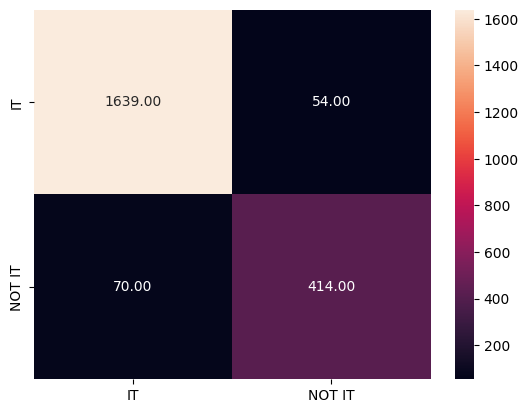

In [72]:
# Create confusion matrix for Test aet

conn_cm_test = metrics.confusion_matrix(rf_test_predict.actual, rf_test_predict.predicted)
sns.heatmap(conn_cm_test, fmt= '.2f', annot=True,  xticklabels=['IT', 'NOT IT'], yticklabels=['IT', 'NOT IT'])

In [73]:
#Create classification report
print(metrics.classification_report(rf_test_predict.actual, rf_test_predict.predicted))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1693
           1       0.88      0.86      0.87       484

    accuracy                           0.94      2177
   macro avg       0.92      0.91      0.92      2177
weighted avg       0.94      0.94      0.94      2177



In [74]:
# Obtain the indices that would sort the feature importances in descending order
indices = np.argsort(rf_model.feature_importances_)[::-1]

# Create an empty DataFrame to store feature ranking information
feature_rank = pd.DataFrame(columns=['rank', 'feature', 'importance'])

# Iterate over each feature
for f in range(train_x.shape[1]):
    # Populate the DataFrame with the rank, feature name, and importance score
    feature_rank.loc[f] = [f + 1,
                           train_x.columns[indices[f]],
                           rf_model.feature_importances_[indices[f]]]

# Round the importance scores to 3 decimal places
feature_rank.round(3)

,rank,feature,importance
0,1,developer,0.087
1,2,software,0.059
2,3,design,0.037
3,4,javascript,0.024
4,5,application,0.023
...,...,...,...
476,477,donor,0.000
477,478,assistant,0.000
478,479,chief,0.000
479,480,officer,0.000


In [75]:
feature_rank[:10]

,rank,feature,importance
0,1,developer,0.086754
1,2,software,0.059301
2,3,design,0.037091
3,4,javascript,0.023610
4,5,application,0.022894
5,6,server,0.020702
6,7,programming,0.018956
7,8,html,0.018551
8,9,experience,0.018039
9,10,web,0.017195


# Similarity of Jobs

In [76]:
# Import the cosine_similarity function from the sklearn.metrics.pairwise module
from sklearn.metrics.pairwise import cosine_similarity

# Define a function to calculate cosine similarity
def get_cosine_sim(doc):
    # Get vectors for each document
    vectors = [t for t in get_vectors(doc)]
    # Calculate cosine similarity between vectors
    return cosine_similarity(vectors)

# Define a function to get vectors from documents
def get_vectors(doc):
    # Convert documents into a list of strings
    text = [t for t in doc]
    # Initialize CountVectorizer with the document text
    vectorizer = CountVectorizer(text)
    # Fit the vectorizer on the text and transform it into a document-term matrix
    vectorizer.fit(text)
    # Return the document-term matrix as an array
    return vectorizer.transform(text).toarray()

In [77]:
from gensim import utils
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

In [78]:
jobpost.head(10)

0    ameria investment consult company job title ch...
1    international research exchange board irex tit...
2    caucasus environmental ngo network cenn job ti...
3    manoff group job title bcc specialist position...
4    yerevan brandy company job title software deve...
5    boutique appollo job title saleswoman position...
6    osi assistance foundation armenian branch offi...
7    international research exchange board irex tit...
8    yerevan brandy company job title assistant man...
9    american embassy yerevan announcement number j...
Name: Jobpost, dtype: object

In [79]:
jobpost.shape

(18865,)

In [80]:
title.head()

0                              chief financial officer
1    fulltime community connection intern pay inter...
2                                  country coordinator
3                                       bcc specialist
4                                   software developer
Name: Title, dtype: object

In [81]:
df_sim = pd.concat([jobpost, title], axis = 1)
df_sim.head(5)

,Jobpost,Title
0,ameria investment consult company job title ch...,chief financial officer
1,international research exchange board irex tit...,fulltime community connection intern pay inter...
2,caucasus environmental ngo network cenn job ti...,country coordinator
3,manoff group job title bcc specialist position...,bcc specialist
4,yerevan brandy company job title software deve...,software developer


In [83]:
# Initialize an empty list to store TaggedDocument objects
docs = []

# Define a function to tag documents
def fn_tag_doc(jobpost, title):
    # Split the jobpost into words and create a TaggedDocument object with the words as the 'words' attribute
    # and the title as the 'tags' attribute
    docs.append(TaggedDocument(words=jobpost.split(), tags=[title]))

# Apply the fn_tag_doc function to each row of the DataFrame df_sim
df_sim.apply(lambda x: fn_tag_doc(x['Jobpost'], x['Title']), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
18996    None
18997    None
18998    None
18999    None
19000    None
Length: 18865, dtype: object

In [84]:
docs[1]

TaggedDocument(words=['international', 'research', 'exchange', 'board', 'irex', 'title', 'fulltime', 'community', 'connection', 'intern', 'pay', 'internship', 'duration', 'month', 'location', 'irex', 'armenia', 'main', 'office', 'yerevan', 'armenia', 'description', 'irex', 'currently', 'seek', 'fill', 'position', 'pay', 'intern', 'community', 'connection', 'cc', 'program', 'position', 'base', 'yerevan', 'office', 'applicant', 'willing', 'travel', 'armenia', 'necessary', 'position', 'report', 'directly', 'cc', 'program', 'manager', 'responsibility', 'present', 'cc', 'program', 'interested', 'party', 'assist', 'planning', 'scheduling', 'programmatic', 'meeting', 'event', 'include', 'coordinate', 'logistic', 'cc', 'staff', 'visitor', 'participant', 'assist', 'program', 'staff', 'translationinterpretation', 'armenian', 'english', 'vice', 'versa', 'help', 'create', 'maintain', 'update', 'cc', 'filing', 'system', 'database', 'complete', 'general', 'administrative', 'task', 'cc', 'program', '

Build a Model to convert each document(jobpost) into vectors to be used to check similarity

In [85]:
model_sim = Doc2Vec(docs, dm=0, alpha = 0.025, min_alpha = 0.025, min_count = 0)

In [86]:
# Iterate over 10 epochs
for epoch in range(10):
    # Train the doc2vec model using the provided documents, updating the model parameters
    model_sim.train(docs, total_examples=model_sim.corpus_count, epochs=model_sim.epochs)
    # Decrease the learning rate by 0.002
    model_sim.alpha -= 0.002
    # Fix the learning rate, preventing further decay
    model_sim.min_alpha = model_sim.alpha

In [87]:
# Show top 10 titles which are similar to the title 'data analyst'.
result = model_sim.docvecs.most_similar(positive=[model_sim.infer_vector('data analyst'.split())],topn=10)

<ipython-input-87-e88a8bdfe4df>:2: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  result = model_sim.docvecs.most_similar(positive=[model_sim.infer_vector('data analyst'.split())],topn=10)


In [88]:
# Create a DataFrame named 'similarity' containing the similarity scores and corresponding job titles
similarity = pd.DataFrame(result, columns=['Job Title', 'Similarity Score'])

similarity.head(10)

,Job Title,Similarity Score
0,business intelligence analyst,0.576741
1,financial analyst,0.556184
2,analyst,0.535977
3,senior data analyst,0.531146
4,property valuation lead specialist,0.515973
5,senior market analyst,0.515859
6,senior financial analyst,0.514081
7,system analyst,0.511580
8,financial analyst controller,0.509728
9,sql data analyst,0.508478
